<a href="https://colab.research.google.com/github/AnastasiaBrinati/Progetto-ML-23-24/blob/main/task1_federato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q flwr["simulation"] tensorflow
!pip install -q flwr_datasets["vision"]
!pip install matplotlib

from typing import Dict, List, Tuple
import tensorflow as tf
import flwr as fl
from flwr.common import Metrics
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth
from datasets import Dataset
from flwr_datasets import FederatedDataset
from keras.initializers import RandomNormal, he_normal, glorot_normal, he_uniform, glorot_uniform

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 9.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.
llmx 0.0

In [2]:
# Simulation parameters
VERBOSE = 0
NUM_CLIENTS = 100 # Total number of clients
FRACTION_FIT = 0.1 # Fraction of clients used for fit
FRACTION_EVALUATE = 0.05 # Fraction of clients used for evaluation
MIN_FIT_CLIENTS = 10 # Minimum number of clients for fit
MIN_EVALUATE_CLIENTS = 5 # Minimum number of clients for evaluation
MIN_AVAILABLE_CLIENTS_FRACTION = 0.75 # Minimum number of available clients
STRATEGY_TYPE = 'FedOptim' # FedAvg, FedOptim, FedProx
NUM_ROUNDS = 10 # Number of rounds for Federated Learning

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
def get_model():
    """Constructs a model suitable for features."""
    # Define input layers
    Support_Calls_input = tf.keras.layers.Input(shape=(1,), name='Support Calls')
    Payment_Delay_input = tf.keras.layers.Input(shape=(1,), name='Payment Delay')
    Usage_Frequency_input = tf.keras.layers.Input(shape=(1,), name='Usage Frequency')
    Total_Spend_input = tf.keras.layers.Input(shape=(1,), name='Total Spend')
    Last_Interaction_input = tf.keras.layers.Input(shape=(1,), name='Last Interaction')
    Age_18_25_input = tf.keras.layers.Input(shape=(1,), name='Age_binned_(18.0, 25.0]')
    Age_25_35_input = tf.keras.layers.Input(shape=(1,), name='Age_binned_(25.0, 35.0]')
    Age_35_50_input = tf.keras.layers.Input(shape=(1,), name='Age_binned_(35.0, 50.0]')
    Age_50_60_input = tf.keras.layers.Input(shape=(1,), name='Age_binned_(50.0, 60.0]')
    Age_60_70_input = tf.keras.layers.Input(shape=(1,), name='Age_binned_(60.0, 70.0]')
    Age_nan_input = tf.keras.layers.Input(shape=(1,), name='Age_binned_nan')
    Contract_Length_Annual_input = tf.keras.layers.Input(shape=(1,), name='Contract Length_Annual')
    Contract_Length_Monthly_input = tf.keras.layers.Input(shape=(1,), name='Contract Length_Monthly')
    Contract_Length_Quarterly_input = tf.keras.layers.Input(shape=(1,), name='Contract Length_Quarterly')
    Contract_Length_nan_input = tf.keras.layers.Input(shape=(1,), name='Contract Length_nan')
    Gender_Female_input = tf.keras.layers.Input(shape=(1,), name='Gender_Female')
    Gender_Male_input = tf.keras.layers.Input(shape=(1,), name='Gender_Male')
    Gender_nan_input = tf.keras.layers.Input(shape=(1,), name='Gender_nan')
    Subscription_Type_Basic_input = tf.keras.layers.Input(shape=(1,), name='Subscription Type_Basic')
    Subscription_Type_Premium_input = tf.keras.layers.Input(shape=(1,), name='Subscription Type_Premium')
    Subscription_Type_Standard_input = tf.keras.layers.Input(shape=(1,), name='Subscription Type_Standard')
    Subscription_Type_nan_input = tf.keras.layers.Input(shape=(1,), name='Subscription Type_nan')

    # Concatenate the input tensors
    concatenated_inputs = tf.keras.layers.concatenate([
        Support_Calls_input, Payment_Delay_input, Usage_Frequency_input, Total_Spend_input, Last_Interaction_input,
        Age_18_25_input, Age_25_35_input, Age_35_50_input, Age_50_60_input, Age_60_70_input, Age_nan_input,
        Contract_Length_Annual_input, Contract_Length_Monthly_input, Contract_Length_Quarterly_input, Contract_Length_nan_input,
        Gender_Female_input, Gender_Male_input, Gender_nan_input,
        Subscription_Type_Basic_input, Subscription_Type_Premium_input, Subscription_Type_Standard_input, Subscription_Type_nan_input
    ])

    # Define the rest of the model
    x = tf.keras.layers.Flatten()(concatenated_inputs)
    x = tf.keras.layers.Dense(80, activation="PReLU", kernel_initializer=he_normal)(x)
    x = tf.keras.layers.Dense(64, activation="relu", kernel_initializer=he_normal)(x)
    x = tf.keras.layers.Dense(16, activation="tanh", kernel_initializer=he_normal)(x)
    x = tf.keras.layers.Dense(32, activation="sigmoid", kernel_initializer=glorot_normal)(x)
    output = tf.keras.layers.Dense(1, activation="sigmoid", kernel_initializer=glorot_normal)(x)

    # Construct the model
    model = tf.keras.models.Model(inputs=[
        Support_Calls_input, Payment_Delay_input, Usage_Frequency_input, Total_Spend_input, Last_Interaction_input,
        Age_18_25_input, Age_25_35_input, Age_35_50_input, Age_50_60_input, Age_60_70_input, Age_nan_input,
        Contract_Length_Annual_input, Contract_Length_Monthly_input, Contract_Length_Quarterly_input, Contract_Length_nan_input,
        Gender_Female_input, Gender_Male_input, Gender_nan_input,
        Subscription_Type_Basic_input, Subscription_Type_Premium_input, Subscription_Type_Standard_input, Subscription_Type_nan_input
    ], outputs=output)

    # Compile the model
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


In [4]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, trainset, valset) -> None:
        # Create model
        self.model = get_model()
        self.trainset = trainset
        self.valset = valset

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.trainset, epochs=1, verbose=VERBOSE)
        return self.model.get_weights(), len(self.trainset), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, acc = self.model.evaluate(self.valset, verbose=VERBOSE)
        return loss, len(self.valset), {"accuracy": acc}

In [5]:
# Download MNIST dataset and partition it
mnist_fds = FederatedDataset(dataset="giulioappetito/churn_dataset_giulioappetito", partitioners={"train": NUM_CLIENTS})
# Get the whole test set for centralised evaluation
centralized_testset = mnist_fds.load_full("test").to_tf_dataset(
  columns=[
            'Support Calls',
            'Payment Delay',
            'Usage Frequency',
            'Total Spend',
            'Last Interaction',
            'Age_binned_(18.0, 25.0]',
            'Age_binned_(25.0, 35.0]',
            'Age_binned_(35.0, 50.0]',
            'Age_binned_(50.0, 60.0]',
            'Age_binned_(60.0, 70.0]',
            'Age_binned_nan',
            'Contract Length_Annual',
            'Contract Length_Monthly',
            'Contract Length_Quarterly',
            'Contract Length_nan',
            'Gender_Female',
            'Gender_Male',
            'Gender_nan',
            'Subscription Type_Basic',
            'Subscription Type_Premium',
            'Subscription Type_Standard',
            'Subscription Type_nan'
        ],
        label_cols="Churn", batch_size=64
    )

/usr/local/lib/python3.10/dist-packages/flwr_datasets/utils.py:84: UserWarning: The currently tested dataset are ['mnist', 'cifar10', 'fashion_mnist', 'sasha/dog-food', 'zh-plus/tiny-imagenet']. Given: giulioappetito/churn_dataset_giulioappetito.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [6]:
# @title
def get_client_fn(dataset: FederatedDataset):
    """Return a function to construct a client.

    The VirtualClientEngine will execute this function whenever a client is sampled by
    the strategy to participate.
    """

    def client_fn(cid: str) -> fl.client.Client:
        """Construct a FlowerClient with its own dataset partition."""

        # Extract partition for client with id = cid
        client_dataset = dataset.load_partition(int(cid), "train")

        # Now let's split it into train (90%) and validation (10%)
        client_dataset_splits = client_dataset.train_test_split(test_size=0.1)
        trainset = client_dataset_splits["train"].to_tf_dataset(
            columns=[
                'Support Calls',
                'Payment Delay',
                'Usage Frequency',
                'Total Spend',
                'Last Interaction',
                'Age_binned_(18.0, 25.0]',
                'Age_binned_(25.0, 35.0]',
                'Age_binned_(35.0, 50.0]',
                'Age_binned_(50.0, 60.0]',
                'Age_binned_(60.0, 70.0]',
                'Age_binned_nan',
                'Contract Length_Annual',
                'Contract Length_Monthly',
                'Contract Length_Quarterly',
                'Contract Length_nan',
                'Gender_Female',
                'Gender_Male',
                'Gender_nan',
                'Subscription Type_Basic',
                'Subscription Type_Premium',
                'Subscription Type_Standard',
                'Subscription Type_nan'
            ],
            label_cols="Churn", batch_size=32
        )
        valset = client_dataset_splits["test"].to_tf_dataset(
            columns=[
                'Support Calls',
                'Payment Delay',
                'Usage Frequency',
                'Total Spend',
                'Last Interaction',
                'Age_binned_(18.0, 25.0]',
                'Age_binned_(25.0, 35.0]',
                'Age_binned_(35.0, 50.0]',
                'Age_binned_(50.0, 60.0]',
                'Age_binned_(60.0, 70.0]',
                'Age_binned_nan',
                'Contract Length_Annual',
                'Contract Length_Monthly',
                'Contract Length_Quarterly',
                'Contract Length_nan',
                'Gender_Female',
                'Gender_Male',
                'Gender_nan',
                'Subscription Type_Basic',
                'Subscription Type_Premium',
                'Subscription Type_Standard',
                'Subscription Type_nan'
            ],
            label_cols="Churn", batch_size=64
        )

        # Create and return client
        return FlowerClient(trainset, valset).to_client()

    return client_fn


def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Aggregation function for (federated) evaluation metrics, i.e. those returned by
    the client's evaluate() method."""
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}


def get_evaluate_fn(testset: Dataset):
    """Return an evaluation function for server-side (i.e. centralised) evaluation."""

    # The `evaluate` function will be called after every round by the strategy
    def evaluate(
        server_round: int,
        parameters: fl.common.NDArrays,
        config: Dict[str, fl.common.Scalar],
    ):
        model = get_model()  # Construct the model
        model.set_weights(parameters)  # Update model with the latest parameters
        loss, accuracy = model.evaluate(testset, verbose=VERBOSE)
        return loss, {"accuracy": accuracy}

    return evaluate


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# Create FedAvg strategy
strategy_FedOptim = fl.server.strategy.FedProx(
    proximal_mu = 1.0,
    fraction_fit=FRACTION_FIT,  # Sample 10% of available clients for training
    fraction_evaluate=FRACTION_EVALUATE,  # Sample 5% of available clients for evaluation
    min_fit_clients=MIN_FIT_CLIENTS, # Never sample less than 10 clients for training
    min_evaluate_clients=MIN_EVALUATE_CLIENTS,  # Never sample less than 5 clients for evaluation
    min_available_clients=int(
        NUM_CLIENTS * MIN_AVAILABLE_CLIENTS_FRACTION
    ),  # Wait until at least 75 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics
    evaluate_fn=get_evaluate_fn(centralized_testset),  # global evaluation function
)

strategy_FedProx = fl.server.strategy.FedProx(
    proximal_mu = 1.0,
    fraction_fit=FRACTION_FIT,  # Sample 10% of available clients for training
    fraction_evaluate=FRACTION_EVALUATE,  # Sample 5% of available clients for evaluation
    min_fit_clients=MIN_FIT_CLIENTS,  # Never sample less than 10 clients for training
    min_evaluate_clients=MIN_EVALUATE_CLIENTS,  # Never sample less than 5 clients for evaluation
    min_available_clients=int(
        NUM_CLIENTS * MIN_AVAILABLE_CLIENTS_FRACTION
    ),  # Wait until at least 75 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics
    evaluate_fn=get_evaluate_fn(centralized_testset),  # global evaluation function
)

strategy_FedAvg = fl.server.strategy.FedAvg(
    fraction_fit=FRACTION_FIT,  # Sample 10% of available clients for training
    fraction_evaluate=FRACTION_EVALUATE,  # Sample 5% of available clients for evaluation
    min_fit_clients=MIN_FIT_CLIENTS,  # Never sample less than 10 clients for training
    min_evaluate_clients=MIN_EVALUATE_CLIENTS,  # Never sample less than 5 clients for evaluation
    min_available_clients=int(
        NUM_CLIENTS * MIN_AVAILABLE_CLIENTS_FRACTION
    ),  # Wait until at least 75 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics
    evaluate_fn=get_evaluate_fn(centralized_testset),  # global evaluation function
)

# Strategy selection
if STRATEGY_TYPE == 'FedProx':
  strategy = strategy_FedProx
elif STRATEGY_TYPE == 'FedOptim':
  strategy = strategy_FedOptim
else:
  strategy = strategy_FedAvg

# Configura le risorse del client
client_resources = {"num_cpus": 1, "num_gpus": 0.0}

# Avvia la simulazione una volta
history = fl.simulation.start_simulation(
    client_fn=get_client_fn(mnist_fds),
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy,
    client_resources=client_resources,
    actor_kwargs={"on_actor_init_fn": enable_tf_gpu_growth}  # Enable GPU growth upon actor init.
)

INFO flwr 2024-02-20 16:05:28,723 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2024-02-20 16:05:34,615	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-02-20 16:05:38,034 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'CPU': 2.0, 'memory': 7794457806.0, 'object_store_memory': 3897228902.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'CPU': 2.0, 'memory': 7794457806.0, 'object_store_memory': 3897228902.0}
INFO flwr 2024-02-20 16:05:38,038 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-02-20 1

history.metrics_centralized = {'accuracy': [(0, 0.43883731961250305), (1, 0.8902634382247925), (2, 0.9064943194389343), (3, 0.9100769758224487), (4, 0.912689745426178), (5, 0.9140060544013977), (6, 0.9149066805839539), (7, 0.9163219332695007), (8, 0.9159161448478699), (9, 0.9178361296653748), (10, 0.9172621369361877)]}


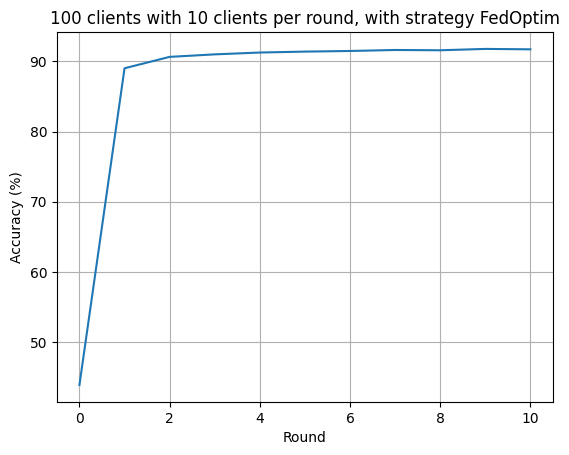

╒═════════╤════════════════╕
│   Round │   Accuracy (%) │
╞═════════╪════════════════╡
│       0 │        43.8837 │
├─────────┼────────────────┤
│       1 │        89.0263 │
├─────────┼────────────────┤
│       2 │        90.6494 │
├─────────┼────────────────┤
│       3 │        91.0077 │
├─────────┼────────────────┤
│       4 │        91.269  │
├─────────┼────────────────┤
│       5 │        91.4006 │
├─────────┼────────────────┤
│       6 │        91.4907 │
├─────────┼────────────────┤
│       7 │        91.6322 │
├─────────┼────────────────┤
│       8 │        91.5916 │
├─────────┼────────────────┤
│       9 │        91.7836 │
├─────────┼────────────────┤
│      10 │        91.7262 │
╘═════════╧════════════════╛


In [9]:
import matplotlib.pyplot as plt
from tabulate import tabulate

# I dati dell'accuratezza
print(f"{history.metrics_centralized = }")
global_accuracy_centralised = history.metrics_centralized["accuracy"]
rounds = [data[0] for data in global_accuracy_centralised]
accuracies = [100.0 * data[1] for data in global_accuracy_centralised]

# Plot
plt.plot(rounds, accuracies)
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.title(str(NUM_CLIENTS) + ' clients with ' + str(int(FRACTION_FIT*NUM_CLIENTS)) + ' clients per round, with strategy ' + STRATEGY_TYPE)  # Correzione qui
plt.show()

# Tabella
data_table = [["Round", "Accuracy (%)"]] + [[r, a] for r, a in zip(rounds, accuracies)]
table = tabulate(data_table, headers="firstrow", tablefmt="fancy_grid")
print(table)